# Stochastic SEI5R model


In the present notebook, we consider the stochastic SEI5R model.

We generate 100 realisations of the stochastic dynamics, and visualise them together with mean, standard deviation, median, and 10- as well as 90-percent quantiles.

**Note: While notebook uses the UK age structure and contact matrix, the model parameters are not fitted to any real data, but rather chosen ad-hoc.**

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

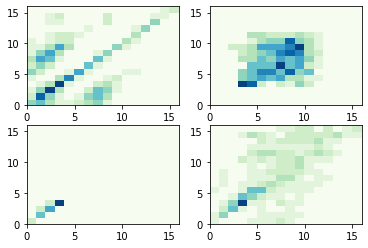

In [4]:
# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.UK()


## matrix of total contacts
C=CH+CW+CS+CO



fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

In [5]:
beta  = 0.036692            # infection rate 

gE    = 1/5
gIa   = 1./7                # removal rate of asymptomatic infectives 
gIs   = 1./7                # removal rate of symptomatic infectives 
alpha = 0.3                 # fraction of asymptomatic infectives 
fsa   = 0.2                   # the self-isolation parameter   
fh    = 0
gIh   = 1/14
gIc   = 1/14
 
sa    = 0        # arrival of new susceptibles

iaa   = 0         # daily arrival of new  asymptomatics

hh   = 0.1*np.ones(M)
cc   = 0.01*np.ones(M)      
mm   = 0.4*np.ones(M)      



# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=8;  Is_0[2:6]=4; Is_0[13:16]=4

Ia_0 = np.zeros((M));  Ia_0[6:13]=4;  Ia_0[2:6]=2; Ia_0[13:16]=2
R_0  = np.zeros((M))
E_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Im_0  = np.zeros((M))

S_0  = Ni - (Ia_0 + Is_0 + R_0)

42.0

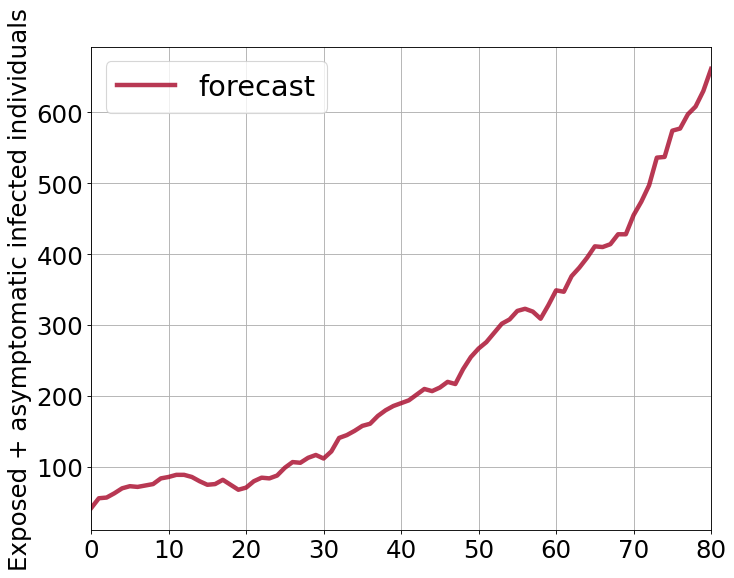

In [6]:
# duration of simulation and data file
Tf=80;  Nf=Tf+1;  



# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'iaa':iaa,
              'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.stochastic.SEI5R(parameters, M, Ni.copy())



# the contact structure is independent of time 
def contactMatrix(t):
    return C
# run model
data=model.simulate(S_0, E_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, contactMatrix, Tf, Nf)


t = data['t']; IC  = np.zeros((Nf))
for i in range(2*M):
        IC += data['X'][:,M+i]
        

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)

 
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Exposed + asymptomatic infected individuals'); #plt.xlim(0, 40); plt.ylim(0, 9999);
#plt.savefig('/Users/rsingh/Desktop/2a.png', format='png', dpi=212)
IC[0]

Since the stochastic SEI5R model is used here, a different trajectory will result every time the above cell is run.

## Averaging over several realisations

We now run 100 simulations, and plot the resulting trajectories together with mean, standard deviations, and quantiles.

In [7]:
# run 100 simulations
N_runs = 100

model = pyross.stochastic.SEI5R(parameters, M, Ni.astype('int'))
trajectories_s = np.zeros([N_runs,Nf,8*M],dtype=float)
for i in range(N_runs):
    print('Running simulation {0} of {1}'.format(i+1,N_runs),end='\r')
    cur_result = model.simulate(S_0, E_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, contactMatrix, Tf, Nf)
    trajectories_s[i] = cur_result['X']
t_s = cur_result['t']

In [8]:
# Calculate mean, standard deviation, and 10 as well as 90 percent quantiles
# for
# - the number of exposed and asymptomatic infectives,
# - the number of symptomatic infectives,
# - the number of hospitalised infectives,
# - the number of infectives in ICU,
# - the number of deceased infectives

trajectories_E_Ia = np.zeros([N_runs,Nf],dtype=float)
trajectories_Is = np.zeros([N_runs,Nf],dtype=float)
trajectories_Ih = np.zeros([N_runs,Nf],dtype=float)
trajectories_Ic = np.zeros([N_runs,Nf],dtype=float)
trajectories_Im = np.zeros([N_runs,Nf],dtype=float)
for i,e in enumerate(trajectories_s):
    for j in range(M):
        trajectories_E_Ia[i] += e[:,j+1*M] + e[:,j+2*M] # E + Ia
        trajectories_Is[i] += e[:,j+3*M] # Is
        trajectories_Ih[i] += e[:,j+4*M] # Ih
        trajectories_Ic[i] += e[:,j+5*M] # Ic
        trajectories_Im[i] += e[:,j+6*M] # Im

        
# mean and standard deviation
mean_E_Ia = np.mean(trajectories_E_Ia, axis = 0)
mean_Is = np.mean(trajectories_Is, axis = 0)
mean_Ih = np.mean(trajectories_Ih, axis = 0)
mean_Ic = np.mean(trajectories_Ic, axis = 0)
mean_Im = np.mean(trajectories_Im, axis = 0)

std_E_Ia = np.std(trajectories_E_Ia, axis = 0)
std_Is = np.std(trajectories_Is, axis = 0)
std_Ih = np.std(trajectories_Ih, axis = 0)
std_Ic = np.std(trajectories_Ic, axis = 0)
std_Im = np.std(trajectories_Im, axis = 0)


# quantiles
percentile = 10

cur_traj = trajectories_E_Ia
percentiles_lower_E_Ia = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_E_Ia = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_E_Ia = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Is
percentiles_lower_Is = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Is = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Is = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Ih
percentiles_lower_Ih = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Ih = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Ih = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Ic
percentiles_lower_Ic = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Ic = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Ic = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Im
percentiles_lower_Im = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Im = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Im = np.percentile(cur_traj,50,axis=0)

## Plot of results from 100 stochastic simulations

In [9]:
def plot_data(t,trajectories,mean,std,median,percentiles_lower,percentiles_upper,
             ylabel='Population'):
    #
    # Trajectories + mean and standard deviation
    #
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    fig.suptitle('Trajectories, with mean and standard deviation')
    ax.fill_between(t,mean-std,mean+std,
                    color='red',alpha=0.1
                   )
    for i,e in enumerate(trajectories):
        ax.plot(t,e,
               alpha=0.3)
    ax.plot(t,mean,lw=3,color='black',label='Mean')
    ax.plot(t,mean+std,lw=2,ls='--',color='red',label='Standard deviation')
    ax.plot(t,mean-std,lw=2,ls='--',color='red')
    ax.set_xlim(np.min(t_s),np.max(t_s))
    ax.set_xlabel('Time [days]')
    ax.set_ylabel(ylabel)
    ax.legend(loc='best')
    plt.show()
    plt.close()
    #
    #
    # Trajectories + percentiles
    #
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    fig.suptitle('Trajectories, with quantiles')
    ax.fill_between(t,percentiles_lower,percentiles_upper,
                    color='red',alpha=0.1
                   )
    for i,e in enumerate(trajectories):
        ax.plot(t,e,
               alpha=0.3)
    ax.plot(t,median,lw=3,color='black',
           label='Median')
    ax.plot(t,mean,lw=3,color='dodgerblue',ls='--',
           label='Mean')
    ax.plot(t,percentiles_lower,lw=2,ls='--',color='red',
           label='Quantiles')
    ax.plot(t,percentiles_upper,lw=2,ls='--',color='red')
    ax.set_xlim(np.min(t_s),np.max(t_s))
    ax.set_xlabel('Time [days]')
    ax.set_ylabel(ylabel)
    ax.legend(loc='best')
    plt.show()
    plt.close()

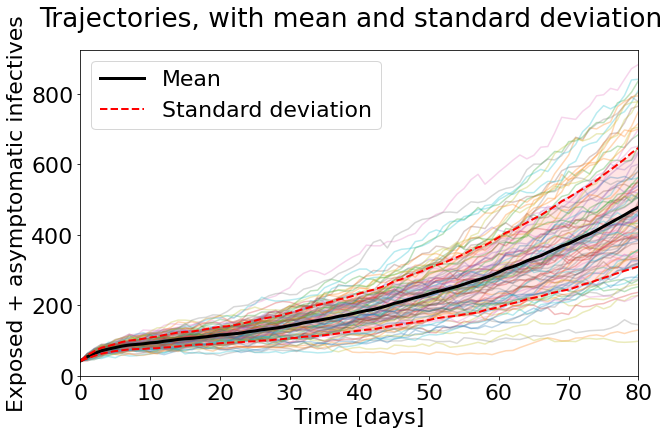

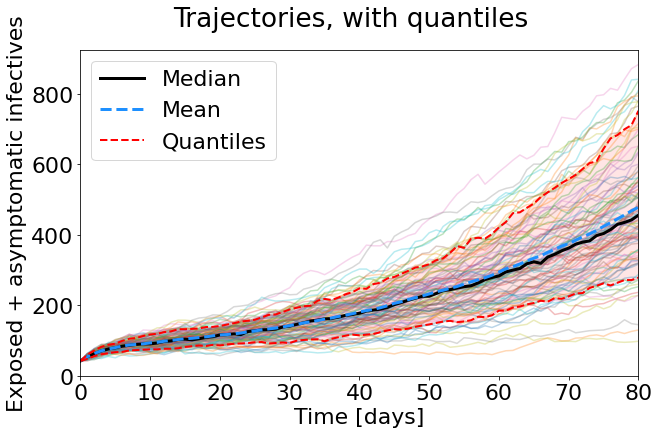

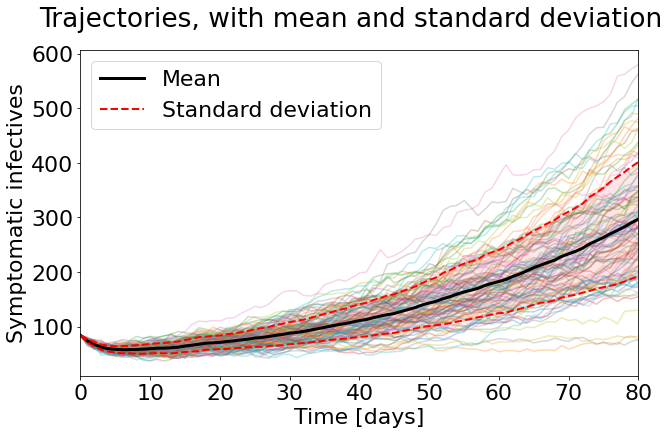

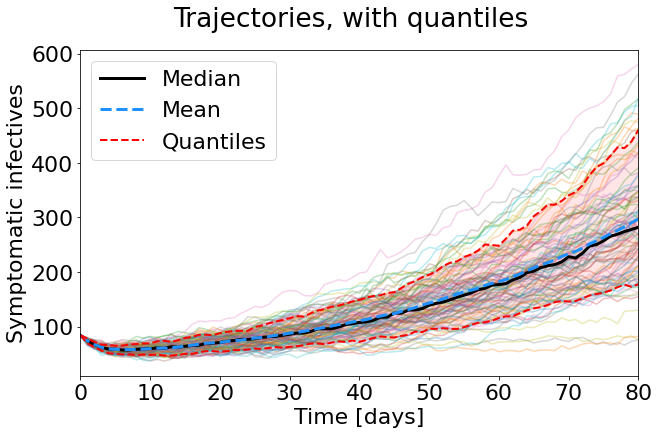

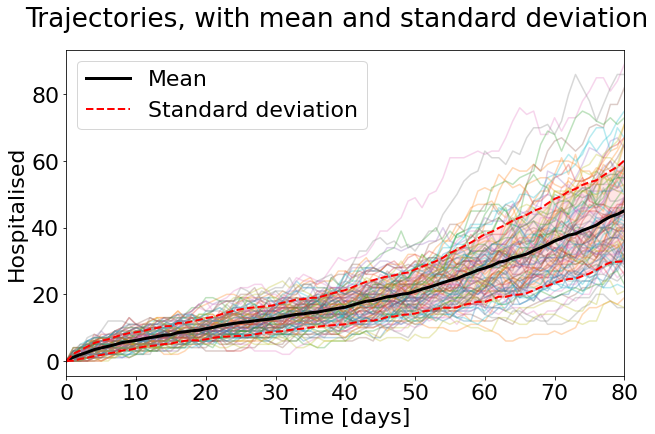

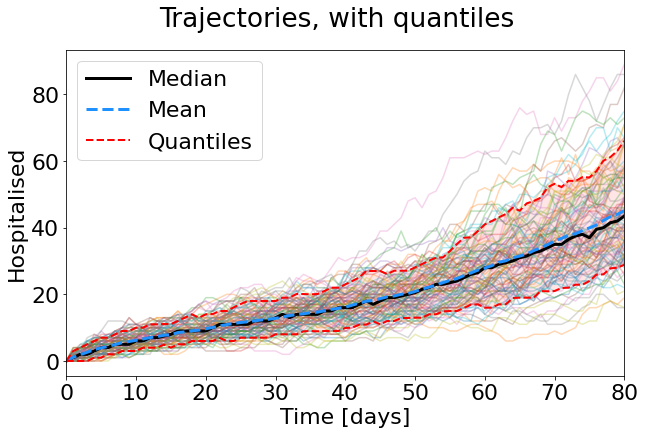

In [10]:
plot_data(t_s,
          trajectories = trajectories_E_Ia,
          mean = mean_E_Ia,  std =std_E_Ia,
         median = percentiles_median_E_Ia, 
          percentiles_lower =percentiles_lower_E_Ia, percentiles_upper =percentiles_upper_E_Ia,
         ylabel=r'Exposed + asymptomatic infectives')


print("\n\n")
plot_data(t_s,
          trajectories = trajectories_Is,
          mean = mean_Is,  std =std_Is,
         median = percentiles_median_Is, 
          percentiles_lower =percentiles_lower_Is, percentiles_upper =percentiles_upper_Is,
         ylabel=r'Symptomatic infectives')


print("\n\n")
plot_data(t_s,
          trajectories = trajectories_Ih,
          mean = mean_Ih,  std =std_Ih,
         median = percentiles_median_Ih, 
          percentiles_lower =percentiles_lower_Ih, percentiles_upper =percentiles_upper_Ih,
         ylabel=r'Hospitalised')